# Natural Language Processing - IMDB Sentiment Analysis

Auf Basis des TensorFlow-Tutorials zur Textklassifikation: <https://www.tensorflow.org/tutorials/keras/text_classification>

## Setup und Importe

In [38]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [39]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydot
import re
import shutil
import string
import tensorflow as tf

from mllib import info
from pathlib import Path
from tensorflow import keras

info()

Python:     3.11.10
TensorFlow: 2.18.0
CUDA:       True
Devices:    PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
MLLib:      0.1.5


## Daten einlesen und vorbereiten

### Einlesen der Daten

In [40]:
dataset_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
data_dir = tf.keras.utils.get_file("aclImdb_v1", origin=dataset_url, extract=True)
data_dir = Path(data_dir)

In [41]:
dataset_dir = Path(data_dir, "aclImdb").resolve()
print(dataset_dir)

/home/juan/.keras/datasets/aclImdb_v1/aclImdb


In [42]:
list(dataset_dir.glob("*"))

[PosixPath('/home/juan/.keras/datasets/aclImdb_v1/aclImdb/imdb.vocab'),
 PosixPath('/home/juan/.keras/datasets/aclImdb_v1/aclImdb/imdbEr.txt'),
 PosixPath('/home/juan/.keras/datasets/aclImdb_v1/aclImdb/train'),
 PosixPath('/home/juan/.keras/datasets/aclImdb_v1/aclImdb/README'),
 PosixPath('/home/juan/.keras/datasets/aclImdb_v1/aclImdb/test')]

In [43]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'train', 'README', 'test']

In [44]:
train_dir = os.path.join(dataset_dir, "train")
os.listdir(train_dir)

['urls_neg.txt',
 'neg',
 'pos',
 'labeledBow.feat',
 'urls_unsup.txt',
 'unsup',
 'urls_pos.txt',
 'unsupBow.feat']

In [45]:
sample_file = os.path.join(train_dir, "pos/1181_9.txt")
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [46]:
# train_dir = Path("/home/juan/.keras/datasets/aclImdb_v1/aclImdb/train")

In [47]:
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

### Dataset einlesen und für die Weiterverarbeitung vorbereiten

Hinweis: Damit keine Daten fehlen oder sowohl im Trainings- als auch im Validierungs-/Testdatensatz landen, muss ein einheitlicher `seed` verwendet werden!

In [48]:
batch_size = 32
seed = 42

#### Trainingsdaten

In [49]:
train_dir = Path(dataset_dir, "train").resolve()

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [50]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Namen der Kategorien (Blumenarten)

In [51]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


#### Validierungsdaten / Testdaten

In [52]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset="validation", 
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [53]:
test_dir = Path(dataset_dir, "test").resolve()

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


### Vorverarbeitung

#### Standardisierung

In [54]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(stripped_html, "[%s]" % re.escape(string.punctuation), "")

#### Vektorisierung

In [55]:
max_features = 10000
sequence_length = 250

vectorize_layer = keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length
)

In [56]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [57]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

### Vorverarbeitete Daten prüfen

In [58]:
# Retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [59]:
first_vec = vectorize_text(first_review, first_label)[0].numpy()[0]

print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))
for i in range(10):
    print(f"{first_vec[i]:4} ---> {vectorize_layer.get_vocabulary()[first_vec[i]]}")

Vocabulary size: 10000
1287 ---> silent
 313 ---> night
2380 ---> deadly
 313 ---> night
 661 ---> 5
   7 ---> is
   2 ---> the
  52 ---> very
 229 ---> last
   5 ---> of


### Datasets erstellen und konfigurieren

In [60]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [25]:
# model_path = "/home/juan/jupyter_projects_ML/05_vorlesung_NaturalLanguageProcessing/nlp/saved_model"

In [26]:
# print(os.listdir('/home/juan/jupyter_projects_ML/05_vorlesung_NaturalLanguageProcessing/nlp/saved_model')

In [27]:
# ep = tf.keras.models.load_model('/zu nlp')

In [61]:
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [62]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Modell aufbauen

Schichten des Modells spezifizieren

In [63]:
embedding_dim = 16

model = keras.Sequential([
    keras.layers.Embedding(max_features, embedding_dim),
    keras.layers.Dropout(0.2),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

In [64]:
model.build()

In [67]:
!pip install graphviz

Die Embedding-Schicht zu Beginn des Modells bildet die 10.000 Wörter des Vokabulars auf einen 16-dimensionalen Embedding-Vektor ab. Das Embedding wird beim Training des Modells mit trainiert. Mehr dazu: <https://www.tensorflow.org/text/guide/word_embeddings>

In [65]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [66]:
keras.utils.plot_model(
    model,
    show_layer_names=False,
    show_layer_activations=True,
    show_shapes=True,
    #to_file="fashion_mnist_cnn.png",
    #dpi=None
)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


## Modell trainieren

Hyperparameter festlegen (zu verwendender Optimizer, Fehlerfunktion / Loss, zu erfassende Metriken)

In [68]:
model.compile(optimizer="adam",
              loss=keras.losses.BinaryCrossentropy(from_logits=True), # es war True
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0)])

In [69]:
epochs=10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - binary_accuracy: 0.5834 - loss: 0.6810 - val_binary_accuracy: 0.7360 - val_loss: 0.6096
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.7618 - loss: 0.5758 - val_binary_accuracy: 0.8150 - val_loss: 0.4938
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8281 - loss: 0.4619 - val_binary_accuracy: 0.8346 - val_loss: 0.4232
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8520 - loss: 0.3919 - val_binary_accuracy: 0.8400 - val_loss: 0.3853
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8672 - loss: 0.3469 - val_binary_accuracy: 0.8526 - val_loss: 0.3576
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8810 - loss: 0.3134 - val_binary_accuracy: 0.8512 - val_loss: 0.3452
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8925 - loss: 0.2888 - val_binary_accuracy: 0.8544 - val_loss: 0.3336
Epoch 

In [70]:
from mllib.results import plot_history

plot_history(history, ["binary_accuracy", "loss"], show_val=True)


## Ergebnisse auswerten

In [71]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8542 - loss: 0.3327
Loss:  0.3335760533809662
Accuracy:  0.8543999791145325


### Trainierte Embedding-Schicht analysieren

In [72]:
model.layers

[<Embedding name=embedding_1, built=True>,
 <Dropout name=dropout_2, built=True>,
 <GlobalAveragePooling1D name=global_average_pooling1d_1, built=True>,
 <Dropout name=dropout_3, built=True>,
 <Dense name=dense_1, built=True>]

In [73]:
embedding_layer = model.layers[0]

In [74]:
weights = embedding_layer.weights[0].numpy()
vocab = vectorize_layer.get_vocabulary()

In [75]:
weights

array([[-0.06595357,  0.01236325, -0.0109098 , ...,  0.00267598,
        -0.07015956, -0.03704429],
       [-0.0418819 ,  0.03703156,  0.00612457, ...,  0.09972071,
         0.05306863, -0.03664163],
       [ 0.08719296,  0.11612292, -0.04933133, ...,  0.11510288,
        -0.16055892,  0.12062909],
       ...,
       [-0.44143885, -0.4303205 , -0.46561548, ..., -0.484634  ,
         0.4209385 , -0.36969486],
       [ 0.54338264,  0.55184233,  0.68631583, ...,  0.5729497 ,
        -0.63059247,  0.61514163],
       [-0.25837228, -0.11180996, -0.10368896, ..., -0.2265697 ,
         0.14242382, -0.18597029]], dtype=float32)

#### Word Embeddings für den TensorFlow Embedding Projector exportieren
<https://projector.tensorflow.org/>

In [76]:
import io

out_v = io.open("imdb_nlp_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("imdb_nlp_metadata.tsv", "w", encoding="utf-8")

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write("\t".join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

#### Embeddings an Beispiel Testen

In [77]:
# Retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
first_vec = vectorize_text(first_review, first_label)[0].numpy()[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", first_vec)

Review tf.Tensor(b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)', shape=(), dtype=string)
Label neg
Vectorized review [   1    7    4 1233 1021   27  261  101    4    1 1525 6992  248   32
 1488    1 1659    4   86 1011   67    1 1707   18  128   27    7  688
 2396    3   84    5   12   27

Embeddings für die 250 Tokens des vektorisierten Inputs

In [78]:
first_embeddings = embedding_layer(first_vec)
first_embeddings

<tf.Tensor: shape=(250, 16), dtype=float32, numpy=
array([[-0.0418819 ,  0.03703156,  0.00612457, ...,  0.09972071,
         0.05306863, -0.03664163],
       [ 0.193687  ,  0.12569934,  0.13497853, ...,  0.21636027,
        -0.16167307,  0.13090731],
       [ 0.12693381,  0.14370441,  0.07343676, ...,  0.10255984,
        -0.0634936 ,  0.0353114 ],
       ...,
       [-0.06595357,  0.01236325, -0.0109098 , ...,  0.00267598,
        -0.07015956, -0.03704429],
       [-0.06595357,  0.01236325, -0.0109098 , ...,  0.00267598,
        -0.07015956, -0.03704429],
       [-0.06595357,  0.01236325, -0.0109098 , ...,  0.00267598,
        -0.07015956, -0.03704429]], dtype=float32)>

Mittelwertbildung durch GlobalAveragePooling1D um das gesamte Review zu repräsentieren

In [79]:
keras.layers.GlobalAveragePooling1D()(tf.expand_dims(first_embeddings, axis=0))

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[-0.03604165,  0.00350043, -0.01385257,  0.01954268,  0.02840083,
         0.04616878,  0.02334546,  0.01554804, -0.05284085,  0.0092675 ,
        -0.01328275,  0.0404039 ,  0.02077501, -0.00366351, -0.03656267,
        -0.03485798]], dtype=float32)>

### End-to-end Modell erstellen und exportieren

In [80]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    keras.layers.Activation("sigmoid") #sigmoid
])

In [81]:
export_model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=["accuracy"]
)

End-to-end Modell mit den Rohdaten (unverarbeitete String mit den Reviews) testen

In [82]:
# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8545 - loss: 0.3320
0.8543999791145325


Mit weiteren Beispiel-Inputs testen

In [83]:
examples = [
    "The movie was great!",
    "The movie was okay.",
    "The movie was terrible..."
]
# export_model.predict(examples)

### Auswertung der Modell-Performance

Vorhersagen für alle Datenpunkte des Test-Datensatzes berechnen

In [84]:
y_test_pred_logits = model.predict(val_ds)
y_test_pred = keras.layers.Activation("sigmoid")(y_test_pred_logits)#sigmoid

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Beispiele überprüfen

In [85]:
y_test_pred

<tf.Tensor: shape=(5000, 1), dtype=float32, numpy=
array([[0.10016247],
       [0.33519688],
       [0.2725758 ],
       ...,
       [0.00123527],
       [0.04514363],
       [0.335475  ]], dtype=float32)>

In [86]:
threshold = 0.5
y_test_pred_classes = tf.cast(y_test_pred >= threshold, tf.int32)

In [87]:
y_test_pred_classes.numpy().ravel()

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [88]:
y_test_classes = []
for _, y in val_ds:
    y_test_classes.extend(y.numpy())
y_test_classes = np.array(y_test_classes)

In [89]:
y_test_classes

array([0, 1, 1, ..., 0, 0, 0], dtype=int32)

In [90]:
sample_idx = 0

print(f"{np.argmax(y_test_classes[sample_idx])}\n\n{y_test_pred[sample_idx]}\n{np.argmax(y_test_pred_classes[sample_idx])}")

0

[0.10016247]
0


Konfusionsmatrix erstellen

In [91]:
class_names = raw_val_ds.class_names

In [92]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [93]:
cm_norm = confusion_matrix(y_test_classes, y_test_pred_classes, normalize="true")
print(cm_norm)

[[0.89926889 0.10073111]
 [0.178487   0.821513  ]]


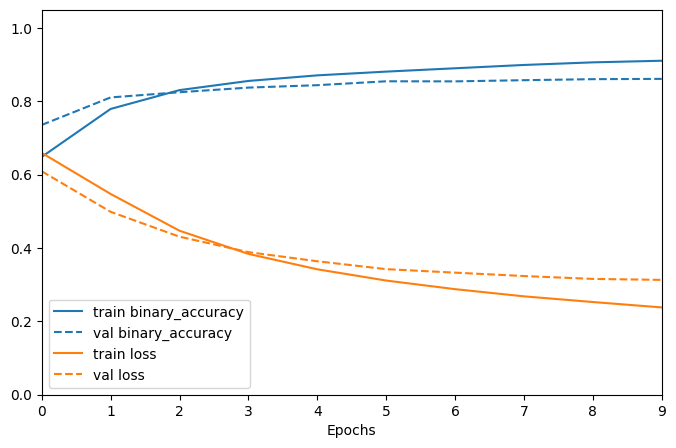

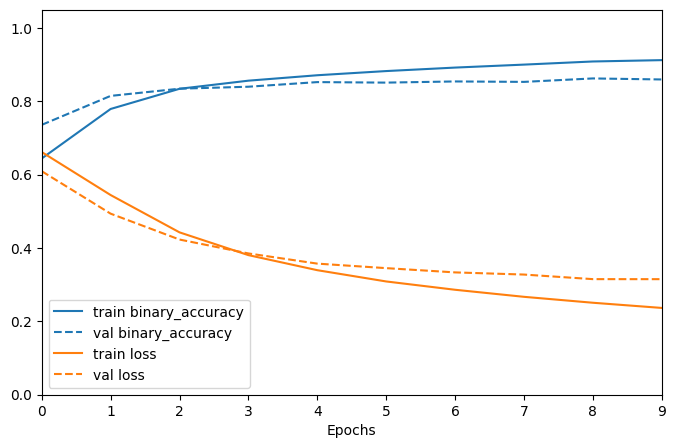

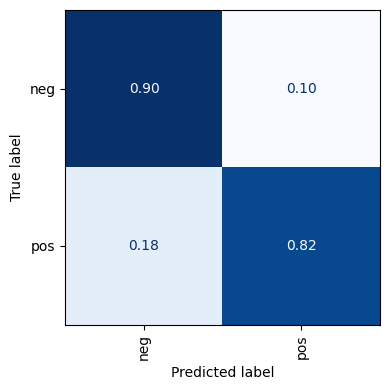

In [94]:
fig, ax = plt.subplots(figsize=(4, 4))
cmd = ConfusionMatrixDisplay(cm_norm, display_labels=class_names)
cmd.plot(ax=ax, values_format=".2f", xticks_rotation="vertical", colorbar=False, cmap="Blues")
plt.tight_layout()
plt.show()

In [95]:
from sklearn.metrics import classification_report

print(classification_report(y_test_classes, y_test_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

         neg       0.83      0.90      0.86      2462
         pos       0.89      0.82      0.86      2538

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



In [96]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(y_test_classes, y_test_pred, plot_chance_level=True)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [97]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(y_test_classes, y_test_pred, plot_chance_level=True)
_ = display.ax_.set_title("2-class ROC curve")

## Model speichern

Siehe auch:
- <https://www.tensorflow.org/tutorials/keras/save_and_load>
- <https://www.tensorflow.org/api_docs/python/tf/keras/saving/save_model>

In [98]:
EXPORT_PATH = Path("saved_models", "imdb_nlp", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")).resolve()
EXPORT_PATH

PosixPath('/home/juan/jupyter_projects_ML/05_vorlesung_NaturalLanguageProcessing/saved_models/imdb_nlp/20250130-063243')

In [102]:
# tf.keras.models.save_model(export_model, EXPORT_PATH)

## Model laden

In [103]:
IMPORT_PATH = Path("saved_models", "imdb_nlp", "20231210-221731").resolve()
IMPORT_PATH

PosixPath('/home/juan/jupyter_projects_ML/05_vorlesung_NaturalLanguageProcessing/saved_models/imdb_nlp/20231210-221731')

In [104]:
#imported_model = tf.keras.models.load_model(IMPORT_PATH)

In [117]:
text_test = "The movie was terrible!"

In [118]:
export_model.predict(tf.convert_to_tensor([text_test]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


array([[0.12782297]], dtype=float32)